In [1]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import os
import torch
#torch.hub.download_url_to_file('https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1', 
#                               'vqgan_imagenet_f16_16384.yaml')
#torch.hub.download_url_to_file('https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1', 
#                               'vqgan_imagenet_f16_16384.ckpt')
import argparse
import math
from pathlib import Path
import sys
sys.path.insert(1, './taming-transformers')

# from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
import matplotlib.pyplot as plt
from taming.models import cond_transformer, vqgan
import taming.modules 
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from urllib.request import urlopen

ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings("ignore")

In [2]:
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))

def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()

def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
    input = input.view([n * c, 1, h, w])
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
    
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

In [3]:
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
replace_grad = ReplaceGrad.apply

class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
clamp_with_grad = ClampWithGrad.apply

In [4]:
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)

class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()

def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])

In [5]:
torch.hub.download_url_to_file('https://images.pexels.com/photos/158028/bellingrath-gardens-alabama-landscape-scenic-158028.jpeg', 
                               'garden.jpeg')
torch.hub.download_url_to_file('https://images.pexels.com/photos/803975/pexels-photo-803975.jpeg', 
                               'cabin.jpeg')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 756k/756k [00:00<00:00, 17.7MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.70M/1.70M [00:00<00:00, 31.5MB/s]


In [6]:
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)

    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)

    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model


In [7]:
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

In [8]:
model_name = "vqgan_imagenet_f16_16384" 
images_interval =  50
width =  512
height = 512
init_image = ""
seed = 42
BASE_PATH = '../input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
args = argparse.Namespace(
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_image=init_image,
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model_name}.yaml',
    vqgan_checkpoint=f'{model_name}.ckpt',
    step_size=0.13,
    cutn=32,
    cut_pow=1.,
    display_freq=images_interval,
    seed=seed,
)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)

Using device: cuda:0
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


In [9]:
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomAffine(degrees=15, translate=0.1, p=0.7, padding_mode='border'),
            K.RandomPerspective(0.7,p=0.7),
            K.ColorJitter(hue=0.1, saturation=0.1, p=0.7),
            K.RandomErasing((.1, .4), (.3, 1/.3), same_on_batch=True, p=0.7),
        )
        self.noise_fac = 0.1
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        slideY, slideX = input.shape[2:4]
        max_size = min(slideX, slideY)
        min_size = min(slideX, slideY, self.cut_size)
        cutouts = []

        for _ in range(self.cutn):
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)

        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch

In [11]:
def inference(text, 
              seed, 
              step_size,
              max_iterations,
              width, 
              height,
              init_image, 
              init_weight, 
              target_images, 
              cutn, 
              cut_pow,
              video_file
             ):
    all_frames = []
    size=[width, height]
    texts = text
    init_weight=init_weight

    if init_image:
        init_image = init_image
    else:
        init_image = ""
    if target_images:
        target_images = target_images
    else:
        target_images = ""
    max_iterations = max_iterations
    model_names={"vqgan_imagenet_f16_16384": 'ImageNet 16384',
                 "vqgan_imagenet_f16_1024":"ImageNet 1024", 
                 'vqgan_openimages_f16_8192':'OpenImages 8912',
                 "wikiart_1024":"WikiArt 1024", 
                 "wikiart_16384":"WikiArt 16384", 
                 "coco":"COCO-Stuff",
                 "faceshq":"FacesHQ",
                 "sflckr":"S-FLCKR"}
    name_model = model_names[model_name]
    if target_images == "None" or not target_images:
        target_images = []
    else:
        target_images = target_images.split("|")
        target_images = [image.strip() for image in target_images]

    texts = [phrase.strip() for phrase in texts.split("|")]
    if texts == ['']:
        texts = []
    if texts:
        print('Using texts:', texts)
    if target_images:
        print('Using image prompts:', target_images)
    if seed is None or seed == -1:
        seed = torch.seed()
    else:
        seed = seed
    torch.manual_seed(seed)
    print('Using seed:', seed)

    cut_size = perceptor.visual.input_resolution
    f = 2**(model.decoder.num_resolutions - 1)
    make_cutouts = MakeCutouts(cut_size, cutn, cut_pow=cut_pow)
    toksX, toksY = size[0] // f, size[1] // f
    sideX, sideY = toksX * f, toksY * f

    if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        e_dim = 256
        n_toks = model.quantize.n_embed
        z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
        z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
    else:
        e_dim = model.quantize.e_dim
        n_toks = model.quantize.n_e
        z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
        z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

    if init_image:
        if 'http' in init_image:
            img = Image.open(urlopen(init_image))
        else:
            img = Image.open(init_image)
        pil_image = img.convert('RGB')
        pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
        pil_tensor = TF.to_tensor(pil_image)
        z, *_ = model.encode(pil_tensor.to(device).unsqueeze(0) * 2 - 1)
    else:
        one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
        # z = one_hot @ model.quantize.embedding.weight
        if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
            z = one_hot @ model.quantize.embed.weight
        else:
            z = one_hot @ model.quantize.embedding.weight
        z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
        z = torch.rand_like(z)*2
    z_orig = z.clone()
    z.requires_grad_(True)
    opt = optim.Adam([z], lr=step_size)
    normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                    std=[0.26862954, 0.26130258, 0.27577711])
    pMs = []

    # Text "prompts"
    for prompt in texts:
        txt, weight, stop = parse_prompt(prompt)
        embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
        pMs.append(Prompt(embed, weight, stop).to(device))

    # Target image "prompts"
    for prompt in target_images:
        path, weight, stop = parse_prompt(prompt)
        img = Image.open(path)
        pil_image = img.convert('RGB')
        img = resize_image(pil_image, (sideX, sideY))
        batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
        embed = perceptor.encode_image(normalize(batch)).float()

        # give more weight to target image
        pMs.append(Prompt(embed, 2.0 * weight, stop).to(device))

    
    for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
        gen = torch.Generator().manual_seed(seed)
        embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
        pMs.append(Prompt(embed, weight).to(device))

    def synth(z):
        if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
            z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
        else:
            z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
        return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)
        
    @torch.no_grad()
    def checkin(i, losses):
        losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
        tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
        out = synth(z)
        # TF.to_pil_image(out[0].cpu()).save('progress.png')
        # display.display(display.Image('progress.png'))
        #res = nvmlDeviceGetUtilizationRates(handle)
        #print(f'gpu: {res.gpu}%, gpu-mem: {res.memory}%')
    def ascend_txt():
        # global i
        out = synth(z)
        iii = perceptor.encode_image(normalize(make_cutouts(out))).float()
        
        result = []
        if init_weight:
            result.append(F.mse_loss(z, z_orig) * init_weight / 2)
            #result.append(F.mse_loss(z, torch.zeros_like(z_orig)) * ((1/torch.tensor(i*2 + 1))*init_weight) / 2)
        for prompt in pMs:
            result.append(prompt(iii))
        img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
        img = np.transpose(img, (1, 2, 0))
        # imageio.imwrite('./steps/' + str(i) + '.png', np.array(img))
        img = Image.fromarray(img).convert('RGB')
        all_frames.append(img)
        return result, np.array(img)
    def train(i):
        opt.zero_grad()
        lossAll, image = ascend_txt()
        if i % args.display_freq == 0:
            checkin(i, lossAll)
        
        loss = sum(lossAll)
        loss.backward()
        opt.step()
        with torch.no_grad():
            z.copy_(z.maximum(z_min).minimum(z_max))
        return image
    i = 0
    try:
        with tqdm() as pbar:
            while True:
                image = train(i)
                if i == max_iterations:
                    break
                i += 1
                pbar.update()
    except KeyboardInterrupt:
        pass
    writer = imageio.get_writer(video_file + '.mp4', fps=20)
    for im in all_frames:
        writer.append_data(np.array(im))
    writer.close()
    return image

In [12]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def display_result(img) :
    plt.figure(figsize=(9,9))
    plt.imshow(img)
    plt.axis('off')

In [22]:
from PIL import Image
img = np.array(Image.open("./tmp.png"))

Using texts: ['a room with one red chair']
Using image prompts: ['./tmp.png']
Using seed: 2


0it [00:00, ?it/s]

i: 0, loss: 1.11936, losses: 0, 0.861685, 0.257677
i: 50, loss: 1.09228, losses: 0.00312212, 0.83406, 0.255102
i: 100, loss: 1.0745, losses: 0.00521025, 0.833768, 0.235526
i: 150, loss: 1.04262, losses: 0.00713634, 0.798196, 0.237283
i: 200, loss: 1.03929, losses: 0.00838679, 0.796239, 0.234664
i: 250, loss: 1.03154, losses: 0.00950453, 0.792901, 0.229134
i: 300, loss: 1.03142, losses: 0.0109403, 0.790231, 0.23025
i: 350, loss: 1.0311, losses: 0.0118018, 0.786156, 0.233141
i: 400, loss: 1.03289, losses: 0.0127389, 0.788376, 0.231776
i: 450, loss: 1.03829, losses: 0.0136665, 0.809094, 0.215527
i: 500, loss: 1.01688, losses: 0.0143411, 0.773361, 0.229177
i: 550, loss: 1.06173, losses: 0.0153953, 0.817706, 0.228625
i: 600, loss: 1.00529, losses: 0.0158719, 0.756104, 0.233315
i: 650, loss: 1.01844, losses: 0.0170052, 0.781759, 0.21968
i: 700, loss: 1.0109, losses: 0.0172278, 0.764468, 0.229204
i: 750, loss: 1.01783, losses: 0.0173516, 0.782873, 0.21761
i: 800, loss: 1.00493, losses: 0.0175

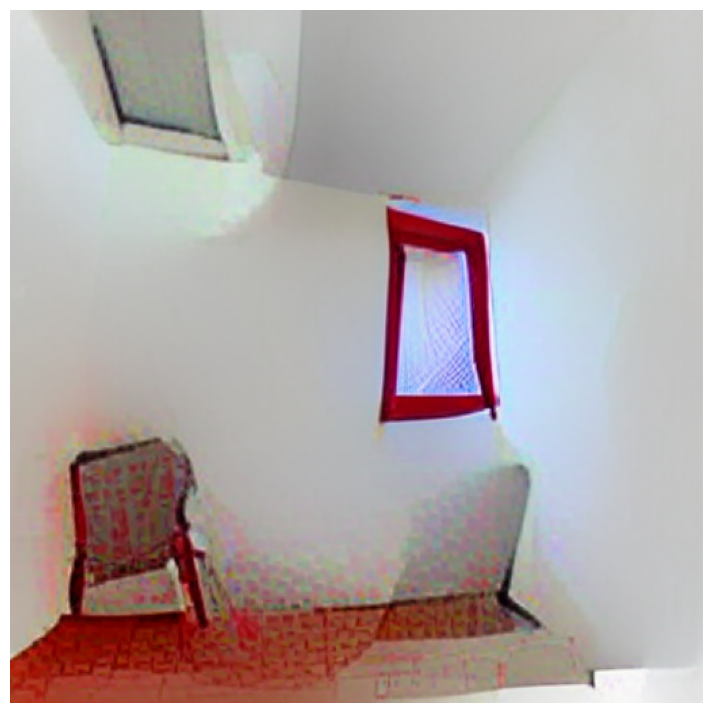

In [31]:
torch.manual_seed(0)
img = inference(
    text = 'a room with one red chair', 
    seed = 2,
    step_size = 0.01,
    max_iterations = 2000,
    width = 512,
    height = 512,
    init_image = './tmp.png',
    init_weight = 0.15,
    target_images = './tmp.png', 
    cutn = 64,
    cut_pow = 0.3,
    video_file = "test1"
)
display_result(img)

# Braindance

In [14]:
import numpy as np
from PIL import Image

def load_im_as_example(im):
    size = [208, 368]
    w,h = im.size
    if np.abs(w/h - size[1]/size[0]) > 0.1:
        print(f"Center cropping image to AR {size[1]/size[0]}")
        if w/h < size[1]/size[0]:
            # crop h
            left = 0
            right = w
            top = h/2 - size[0]/size[1]*w/2
            bottom = h/2 + size[0]/size[1]*w/2
        else:
            # crop w
            top = 0
            bottom = h
            left = w/2 - size[1]/size[0]*h
            right = w/2 + size[1]/size[0]*h
        im = im.crop(box=(left, top, right, bottom))

    im = im.resize((size[1],size[0]),
                   resample=Image.LANCZOS)
    im = np.array(im)/127.5-1.0
    im = im.astype(np.float32)

    example = dict()
    example["src_img"] = im
    example["K"] = np.array([[184.0, 0.0, 184.0],
                             [0.0, 184.0, 104.0],
                             [0.0, 0.0, 1.0]], dtype=np.float32)
    example["K_inv"] = np.linalg.inv(example["K"])

    ## dummy data not used during inference
    example["dst_img"] = np.zeros_like(example["src_img"])
    example["src_points"] = np.zeros((1,3), dtype=np.float32)

    return example

def load_as_example(path):
    im = Image.open(path)
    return load_im_as_example(im)

In [15]:
def normalize(x):
    return x/np.linalg.norm(x)

def cosd(x):
    return np.cos(np.deg2rad(x))

def sind(x):
    return np.sin(np.deg2rad(x))

def look_to(camera_pos, camera_dir, camera_up):
  camera_right = normalize(np.cross(camera_up, camera_dir))
  R = np.zeros((4, 4))
  R[0,0:3] = normalize(camera_right)
  R[1,0:3] = normalize(np.cross(camera_dir, camera_right))
  R[2,0:3] = normalize(camera_dir)
  R[3,3] = 1
  trans_matrix = np.array([[1.0, 0.0, 0.0, -camera_pos[0]],
                           [0.0, 1.0, 0.0, -camera_pos[1]],
                           [0.0, 0.0, 1.0, -camera_pos[2]],
                           [0.0, 0.0, 0.0,            1.0]])
  tmp = R@trans_matrix
  return tmp[:3,:3], tmp[:3,3]

def rotate_around_axis(angle, axis):
    axis = normalize(axis)
    rotation = np.array([[cosd(angle)+axis[0]**2*(1-cosd(angle)),
                          axis[0]*axis[1]*(1-cosd(angle))-axis[2]*sind(angle),
                          axis[0]*axis[2]*(1-cosd(angle))+axis[1]*sind(angle)],
                         [axis[1]*axis[0]*(1-cosd(angle))+axis[2]*sind(angle),
                          cosd(angle)+axis[1]**2*(1-cosd(angle)),
                          axis[1]*axis[2]*(1-cosd(angle))-axis[0]*sind(angle)],
                         [axis[2]*axis[0]*(1-cosd(angle))-axis[1]*sind(angle),
                          axis[2]*axis[1]*(1-cosd(angle))+axis[0]*sind(angle),
                          cosd(angle)+axis[2]**2*(1-cosd(angle))]])
    return rotation

In [16]:
import torch
from splatting import splatting_function

def render_forward(src_ims, src_dms,
                   Rcam, tcam,
                   K_src,
                   K_dst):
    Rcam = Rcam.to(device=src_ims.device)[None]
    tcam = tcam.to(device=src_ims.device)[None]

    R = Rcam
    t = tcam[...,None]
    K_src_inv = K_src.inverse()

    assert len(src_ims.shape) == 4
    assert len(src_dms.shape) == 3
    assert src_ims.shape[1:3] == src_dms.shape[1:3], (src_ims.shape,
                                                      src_dms.shape)

    x = np.arange(src_ims[0].shape[1])
    y = np.arange(src_ims[0].shape[0])
    coord = np.stack(np.meshgrid(x,y), -1)
    coord = np.concatenate((coord, np.ones_like(coord)[:,:,[0]]), -1) # z=1
    coord = coord.astype(np.float32)
    coord = torch.as_tensor(coord, dtype=K_src.dtype, device=K_src.device)
    coord = coord[None] # bs, h, w, 3

    D = src_dms[:,:,:,None,None]

    points = K_dst[None,None,None,...]@(R[:,None,None,...]@(D*K_src_inv[None,None,None,...]@coord[:,:,:,:,None])+t[:,None,None,:,:])
    points = points.squeeze(-1)

    new_z = points[:,:,:,[2]].clone().permute(0,3,1,2) # b,1,h,w
    points = points/torch.clamp(points[:,:,:,[2]], 1e-8, None)

    src_ims = src_ims.permute(0,3,1,2)
    flow = points - coord
    flow = flow.permute(0,3,1,2)[:,:2,...]

    alpha = 0.5
    importance = alpha/new_z
    importance_min = importance.amin((1,2,3),keepdim=True)
    importance_max = importance.amax((1,2,3),keepdim=True)
    importance=(importance-importance_min)/(importance_max-importance_min+1e-6)*10-10
    importance = importance.exp()

    input_data = torch.cat([importance*src_ims, importance], 1)
    output_data = splatting_function("summation", input_data, flow)

    num = torch.sum(output_data[:,:-1,:,:], dim=0, keepdim=True)
    nom = torch.sum(output_data[:,-1:,:,:], dim=0, keepdim=True)

    rendered = num/(nom+1e-7)
    rendered = rendered.permute(0,2,3,1)[0,...]
    return rendered

In [17]:
import importlib
from geofree import pretrained_models
from torch.utils.data.dataloader import default_collate

class Renderer(object):
    def __init__(self, model, device):
        self.model = pretrained_models(model=model)
        self.model = self.model.to(device=device)
        self._active = False

    def init(self,
             start_im,
             example,
             show_R,
             show_t):
        self._active = True
        self.step = 0

        batch = self.batch = default_collate([example])
        batch["R_rel"] = show_R[None,...]
        batch["t_rel"] = show_t[None,...]

        _, cdict, edict = self.model.get_xce(batch)
        for k in cdict:
            cdict[k] = cdict[k].to(device=self.model.device)
        for k in edict:
            edict[k] = edict[k].to(device=self.model.device)

        quant_d, quant_c, dc_indices, embeddings = self.model.get_normalized_c(cdict,edict,fixed_scale=True)

        start_im = start_im[None,...].to(self.model.device).permute(0,3,1,2)
        quant_c, c_indices = self.model.encode_to_c(c=start_im)
        cond_rec = self.model.cond_stage_model.decode(quant_c)

        self.current_im = cond_rec.permute(0,2,3,1)[0]
        self.current_sample = c_indices

        self.quant_c = quant_c # to know shape
        # for sampling
        self.dc_indices = dc_indices
        self.embeddings = embeddings

    def __call__(self):
        if self.step < self.current_sample.shape[1]:
            z_start_indices = self.current_sample[:, :self.step]
            temperature=None
            top_k=250
            callback=None
            index_sample = self.model.sample(z_start_indices, self.dc_indices,
                                             steps=1,
                                             temperature=temperature if temperature is not None else 1.0,
                                             sample=True,
                                             top_k=top_k if top_k is not None else 100,
                                             callback=callback if callback is not None else lambda k: None,
                                             embeddings=self.embeddings)
            self.current_sample = torch.cat((index_sample,
                                             self.current_sample[:,self.step+1:]),
                                            dim=1)

            sample_dec = self.model.decode_to_img(self.current_sample,
                                                  self.quant_c.shape)
            self.current_im = sample_dec.permute(0,2,3,1)[0]
            self.step += 1

        if self.step >= self.current_sample.shape[1]:
            self._active = False

        return self.current_im

    def active(self):
        return self._active

    def reconstruct(self, x):
        x = x.to(self.model.device).permute(0,3,1,2)
        quant_c, c_indices = self.model.encode_to_c(c=x)
        x_rec = self.model.cond_stage_model.decode(quant_c)
        return x_rec.permute(0,2,3,1)

In [18]:
from geofree.modules.warp.midas import Midas

depth_model_name = "re_impl_depth"
torch.set_grad_enabled(False)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("Warning: Running on CPU---sampling might take a while...")
    device = torch.device("cpu")
midas = Midas().eval().to(device)
renderer = Renderer(model=depth_model_name, device=device)

Using cache found in /home/xin/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/xin/.cache/torch/hub/facebookresearch_WSL-Images_main


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from /home/xin/.cache/geofree/re_first_stage/last.ckpt
Using first stage also as cond stage.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from /home/xin/.cache/geofree/re_depth_stage/last.ckpt


Using cache found in /home/xin/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/xin/.cache/torch/hub/facebookresearch_WSL-Images_main


Loading weights:  None
Restored model from /home/xin/.cache/geofree/re_impl_depth/last.ckpt


In [19]:
class Looper(object):
    def __init__(self, midas, renderer, example):
        self.midas = midas
        self.renderer = renderer
        self.init_example(example)
        self.RENDERING = False
  
    def init_example(self, example):
        self.example = example

        ims = example["src_img"][None,...]
        K = example["K"]

        # compute depth for preview
        dms = [None]
        for i in range(ims.shape[0]):
            midas_in = torch.tensor(ims[i])[None,...].permute(0,3,1,2).to(device)
            scaled_idepth = self.midas.fixed_scale_depth(midas_in, return_inverse_depth=True)
            dms[i] = 1.0/scaled_idepth[0].cpu().numpy()

        # now switch to pytorch
        src_ims = torch.tensor(ims, dtype=torch.float32)
        src_dms = torch.tensor(dms, dtype=torch.float32)
        K = torch.tensor(K, dtype=torch.float32)

        self.src_ims = src_ims.to(device=device)
        self.src_dms = src_dms.to(device=device)
        self.K = K.to(device=device)

        self.init_cam()

    def init_cam(self):
        self.camera_pos = np.array([0.0, 0.0, 0.0])
        self.camera_dir = np.array([0.0, 0.0, 1.0])
        self.camera_up = np.array([0.0, 1.0, 0.0])
        self.CAM_SPEED = 0.25
        self.MOUSE_SENSITIVITY = 10.0

    def update_camera(self, keys):
        ######### Camera
        if keys["a"]:
            self.camera_pos += self.CAM_SPEED*normalize(np.cross(self.camera_dir, self.camera_up))
        if keys["d"]:
            self.camera_pos -= self.CAM_SPEED*normalize(np.cross(self.camera_dir, self.camera_up))
        if keys["w"]:
            self.camera_pos += self.CAM_SPEED*normalize(self.camera_dir)
        if keys["s"]:
            self.camera_pos -= self.CAM_SPEED*normalize(self.camera_dir)
        if keys["q"]:
            self.camera_pos -= self.CAM_SPEED*normalize(self.camera_up)
        if keys["e"]:
            self.camera_pos += self.CAM_SPEED*normalize(self.camera_up)

        camera_yaw = 0
        camera_pitch = 0
        if "look" in keys:
            dx, dy = keys["look"]
            if not self.RENDERING:
                camera_yaw -= self.MOUSE_SENSITIVITY*dx
                camera_pitch += self.MOUSE_SENSITIVITY*dy

        # adjust for yaw and pitch
        rotation = np.array([[cosd(-camera_yaw), 0.0, sind(-camera_yaw)],
                             [0.0, 1.0, 0.0],
                             [-sind(-camera_yaw), 0.0, cosd(-camera_yaw)]])
        self.camera_dir = rotation@self.camera_dir

        rotation = rotate_around_axis(camera_pitch, np.cross(self.camera_dir,
                                                             self.camera_up))
        self.camera_dir = rotation@self.camera_dir

        show_R, show_t = look_to(self.camera_pos, self.camera_dir, self.camera_up) # look from pos in direction dir
        show_R = torch.as_tensor(show_R, dtype=torch.float32)
        show_t = torch.as_tensor(show_t, dtype=torch.float32)

        self.show_R = show_R
        self.show_t = show_t

    def update(self, keys):
        self.update_camera(keys)
        if not self.RENDERING:
            wrp_im = render_forward(self.src_ims, self.src_dms,
                                    self.show_R, self.show_t,
                                    K_src=self.K,
                                    K_dst=self.K)
            
        if keys["render"]:
            self.RENDERING = True
            self.renderer.init(wrp_im, self.example, self.show_R, self.show_t)

        if self.RENDERING:
            wrp_im = self.renderer()
        
        if not self.renderer._active or keys["stop"]:
          self.RENDERING = False

        return wrp_im, self.RENDERING

In [20]:
example = load_as_example("./smallroom.jpg")

Center cropping image to AR 1.7692307692307692


In [21]:
looper = Looper(midas, renderer, example)

In [22]:
from collections import defaultdict

keys = defaultdict(bool)
keys["s"] = True
keys["look"] = (1.0, 0.0)
keys["look"] = np.array(keys["look"])*2.0-1.0

warp_im, rendering = looper.update(keys)
looper.show_R, looper.show_t

(tensor([[ 0.9848,  0.0000, -0.1736],
         [ 0.0302,  0.9848,  0.1710],
         [ 0.1710, -0.1736,  0.9698]]),
 tensor([-0.0434,  0.0428,  0.2425]))

In [23]:
wrp_im = render_forward(looper.src_ims, looper.src_dms,
                                    looper.show_R, looper.show_t,
                                    K_src=looper.K,
                                    K_dst=looper.K)
looper.renderer.init(wrp_im, looper.example, looper.show_R, looper.show_t)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


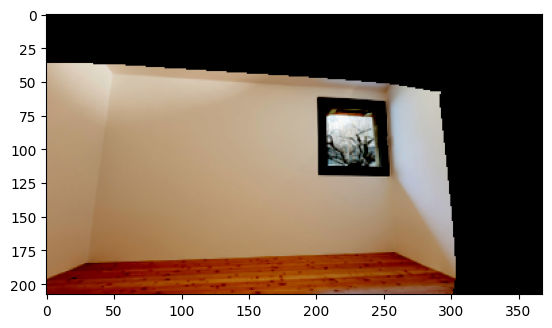

In [24]:
plt.imshow(wrp_im.detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


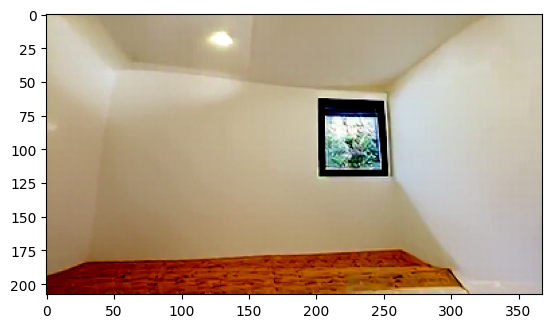

In [25]:
while looper.renderer._active:
    wrp_im = looper.renderer()
plt.imshow(wrp_im.detach().cpu().numpy())

In [26]:
tmp_im = 255. * (wrp_im - wrp_im.min()) / (wrp_im.max() - wrp_im.min())
tmp_im = tmp_im.detach().cpu().numpy().astype(np.uint8)
Image.fromarray(tmp_im).save("tmp.png")